In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/agriculture-data/cleaned_text_data.csv


# Data Preparation

In [2]:
# GPU-accelerated HDBSCAN + UMAP
!pip install cudf-cu12 dask-cudf-cu12 --extra-index-url=https://pypi.nvidia.com --q
!pip install cuml-cu12 --extra-index-url=https://pypi.nvidia.com --q
!pip install cugraph-cu12 --extra-index-url=https://pypi.nvidia.com --q
!pip install cupy-cuda12x -f https://pip.cupy.dev/aarch64 --q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 30.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.9/133.9 kB 131.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 74.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 851.2/851.2 kB 200.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.5/293.5 MB 75.7 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 180.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.7/557.7 MB 50.3 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.3/27.3 MB 155.8 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 163.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 172.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 725.3/725.3 kB 181.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.

In [3]:
data = pd.read_csv('/kaggle/input/agriculture-data/cleaned_text_data.csv')

In [4]:
from typing import List
import re

In [5]:
def chunk_document(text: str, chunk_size: int = 300) -> List[str]:
    try:
        # Basic sentence splitting using common sentence endings
        sentences = re.split(r'(?<=[.!?])\s+', text)
        
        chunks = []
        current_chunk = []
        current_size = 0
        
        for sentence in sentences:
            words = sentence.split()
            if current_size + len(words) <= chunk_size:
                current_chunk.append(sentence)
                current_size += len(words)
            else:
                if current_chunk:
                    chunks.append(' '.join(current_chunk))
                current_chunk = [sentence]
                current_size = len(words)
        
        if current_chunk:
            chunks.append(' '.join(current_chunk))
        
        return chunks
    except Exception as e:
        print(f"Error chunking document: {e}")
        return [text]  # Return original text if chunking fails

In [6]:
chunked_data = []

for idx, row in data.iterrows():
    text = row['text']
    chunks = chunk_document(text, chunk_size=300)  # Adjust chunk_size as needed
    
    for chunk in chunks:
        chunked_data.append({'original_index': idx, 'chunk': chunk})

In [7]:
chunked_df = pd.DataFrame(chunked_data)

In [8]:
print("Shape of chunked DataFrame:", chunked_df.shape)

Shape of chunked DataFrame: (58144, 2)


In [9]:
chunked_df.columns

Index(['original_index', 'chunk'], dtype='object')

In [10]:
print(chunked_df.iloc[3]['chunk'])  # Access 4th row (index = 3)

Hello and welcome to the ZimmCast. This podcast was started back in 2004 with a theme of what's new in the world of agribusiness focusing on agricultural marketing in particular. I really appreciate all the subscribers and listeners who have made this the longest running podcast about agriculture. The feedback and support has been great and I've had the opportunity to talk with many, many leaders in the industry. So, what's this week's episode about? It's about agriculture's economic impact on a very urban region, specifically St. Louis. The St. Louis Agribusiness Club just announced the results of their Agricultural Economic Impact Study on the St. Louis Region. This study has been conducted every five years since the first one was conducted in 2004. And guess what. ZimmComm produced that first study and you can still see those results on the organization's website. To talk about the study I'm going to share conversations with Matt Amick, Missouri Soybean Association and President of 

# Topic Modelling


In [11]:
!pip install bertopic --q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.6/150.6 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 57.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 34.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 11.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 74.7 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does

# SLM

# Prompt Engineering

We pass the LLM to BERTopic with a custom prompt. We also add KeyBERTInspired, MMR and POS representations to compare the LLM representations with:

In [19]:
from transformers import pipeline
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance, PartOfSpeech, TextGeneration

# Load components
keybert = KeyBERTInspired()
pos_model = PartOfSpeech("en_core_web_sm")
mmr = MaximalMarginalRelevance(diversity=0.3)

# Load FLAN-T5 pipeline
generator = pipeline("text2text-generation", model="google/flan-t5-small")

prompt = (
    "Generate a short topic label in natural language (maximum 5 words) based on the following keywords and documents.\n\n"
    "Keywords: [KEYWORDS]\n"
    "Documents:\n[DOCUMENTS]"
)

# Add to representation model
representation_model = {
    "KeyBERT": keybert,
    "SLM": TextGeneration(model=generator, prompt=prompt),
    "MMR": mmr,
    "POS": pos_model
}


Device set to use cuda:0


# BERTopic


By pre-calculating the embeddings for each document, we can speed-up additional exploration steps and use the embeddings to quickly iterate over BERTopic's hyperparameters if needed.

In [13]:
docs= chunked_df['chunk']

In [14]:
from sentence_transformers import SentenceTransformer
from cuml.manifold import UMAP
from cuml.cluster import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.vectorizers import ClassTfidfTransformer

# Pre-calculate embeddings
embedding_model = SentenceTransformer("BAAI/bge-small-en", device="cuda")
embeddings = embedding_model.encode(docs, show_progress_bar=True)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/90.8k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1817 [00:00<?, ?it/s]

In [15]:
# Pre-reduce embeddings for visualization purposes
reduced_embeddings = UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine', random_state=42).fit_transform(embeddings)

[2025-05-04 20:03:17.019] [CUML] [info] build_algo set to brute_force_knn because random_state is given


In [16]:
umap_model = UMAP(n_neighbors=10, n_components=3, min_dist=0.1, metric='cosine', random_state=42, low_memory=True)
# hdbscan_model = HDBSCAN(min_cluster_size=150, metric='euclidean', cluster_selection_method='eom', prediction_data=True)
hdbscan_model = HDBSCAN(min_cluster_size=100, min_samples=5, metric='euclidean', cluster_selection_method='eom', prediction_data=True)
vectorizer_model = CountVectorizer(stop_words="english", ngram_range=(2, 2))

[2025-05-04 20:03:19.495] [CUML] [info] Unused keyword parameter: low_memory during cuML estimator initialization
[2025-05-04 20:03:19.497] [CUML] [info] build_algo set to brute_force_knn because random_state is given


# Training

In [20]:
from bertopic import BERTopic

topic_model = BERTopic(

  # Sub-models
  embedding_model=embedding_model,
  umap_model=umap_model,
  hdbscan_model=hdbscan_model,
  representation_model=representation_model,
    vectorizer_model= vectorizer_model,
    top_n_words=10,
verbose=True)

# Train model
topics, probs = topic_model.fit_transform(docs, embeddings)

2025-05-04 20:11:48,991 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-05-04 20:11:51,449 - BERTopic - Dimensionality - Completed ✓
2025-05-04 20:11:51,452 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-05-04 20:11:52,719 - BERTopic - Cluster - Completed ✓
2025-05-04 20:11:52,733 - BERTopic - Representation - Fine-tuning topics using representation models.
100%|██████████| 99/99 [00:30<00:00,  3.20it/s]
2025-05-04 20:14:34,873 - BERTopic - Representation - Completed ✓


In [22]:
# Show topics
topic_info =topic_model.get_topic_info()
topic_info.head()

,Topic,Count,Name,Representation,KeyBERT,SLM,MMR,POS,Representative_Docs
0,-1,25643,-1_plant based_climate change_soy sauce_covid 19,"[plant based, climate change, soy sauce, covid...","[agric4profits com, farms com, market place, p...",[All cookbook recipes in the cookbook index ar...,"[plant based, climate change, soy sauce, suppl...","[long term, high quality, organic matter, soci...",[All cookbook recipes in the cookbook index ar...
1,0,2522,0_agri food_farms com_agriculture agri_ministe...,"[agri food, farms com, agriculture agri, minis...","[canadian farmers, canadian agriculture, farme...",[Canada's chicken and turkey farmers deliver t...,"[agri food, minister agriculture, farmers onta...","[federal government, long term, economic devel...","[ECOCERT Canada, Canadian Forage and Grassland..."
2,1,1941,1_john deere_new holland_case ih_self propelled,"[john deere, new holland, case ih, self propel...","[john deere, agricultural machinery, deere dea...",[John Deere received 2022 AE50 Awards for inno...,"[john deere, new holland, self propelled, mass...","[heavy duty, hydrostatic transmission, real ti...",[Company takes home eight 2022 AE50 Awards for...
3,2,1685,2_crop insurance_farmers ranchers_climate smar...,"[crop insurance, farmers ranchers, climate sma...","[usda transforming, usda touches, usda announc...","[USDA is an equal opportunity provider, employ...","[crop insurance, farmers ranchers, climate sma...","[technical assistance, sustainable agriculture...","[Under the Biden-Harris Administration, USDA i..."
4,3,1020,3_oilseed rape_yellow rust_winter wheat_winter...,"[oilseed rape, yellow rust, winter wheat, wint...","[barley crops, spring crops, cover crops, crop...","[weed control, spring barley, winter barley, w...","[oilseed rape, yellow rust, winter wheat, weed...","[yellow rust, light leaf, specific weight, ind...",[Most winter wheat crops look to have good yie...


In [33]:
topic_info.to_csv('slm_topic_info_first.csv', index=False)

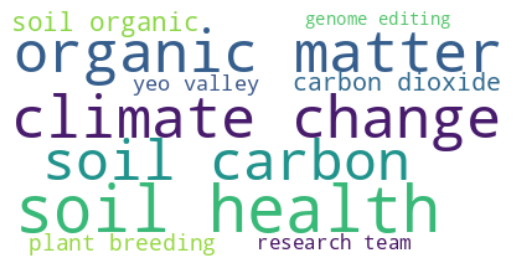

In [32]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def create_wordcloud(model, topic):
    text = {word: value for word, value in model.get_topic(topic)}
    wc = WordCloud(background_color="white", max_words=1000)
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

# Show wordcloud
create_wordcloud(topic_model, topic=8)

In [44]:
# Reduce outliers using the `c-tf-idf` strategy
new_topics = topic_model.reduce_outliers(docs, topics, strategy="c-tf-idf")

In [37]:
topic_model.update_topics(docs, topics=new_topics)

2025-05-04 20:30:50,128 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


In [40]:
updated_topics = topic_model.get_topic_info()
updated_topics.head()

,Topic,Count,Name,Representation,KeyBERT,SLM,MMR,POS,Representative_Docs
0,-1,75,-1_doc_google_click_here,"[doc, google, click, here, see, choicecards, m...","[agric4profits com, farms com, market place, p...",[All cookbook recipes in the cookbook index ar...,"[plant based, climate change, soy sauce, suppl...","[long term, high quality, organic matter, soci...",[All cookbook recipes in the cookbook index ar...
1,0,3906,0_canada_agriculture_and_to,"[canada, agriculture, and, to, the, ontario, o...","[canadian farmers, canadian agriculture, farme...",[Canada's chicken and turkey farmers deliver t...,"[agri food, minister agriculture, farmers onta...","[federal government, long term, economic devel...","[ECOCERT Canada, Canadian Forage and Grassland..."
2,1,2408,1_deere_tractor_the_with,"[deere, tractor, the, with, it, john, and, to,...","[john deere, agricultural machinery, deere dea...",[John Deere received 2022 AE50 Awards for inno...,"[john deere, new holland, self propelled, mass...","[heavy duty, hydrostatic transmission, real ti...",[Company takes home eight 2022 AE50 Awards for...
3,2,2469,2_usda_program_food_and,"[usda, program, food, and, agriculture, to, pr...","[usda transforming, usda touches, usda announc...","[USDA is an equal opportunity provider, employ...","[crop insurance, farmers ranchers, climate sma...","[technical assistance, sustainable agriculture...","[Under the Biden-Harris Administration, USDA i..."
4,3,1581,3_crops_winter_spring_wheat,"[crops, winter, spring, wheat, resistance, wit...","[barley crops, spring crops, cover crops, crop...","[weed control, spring barley, winter barley, w...","[oilseed rape, yellow rust, winter wheat, weed...","[yellow rust, light leaf, specific weight, ind...",[Most winter wheat crops look to have good yie...


In [50]:
updated_topics.to_csv('reduced_outliers_topics.csv', index = False)

In [41]:
num_topics = len(topic_model.get_topic_info())
print("Number of topics found:", num_topics)

Number of topics found: 99


In [49]:
sample_doc = topic_model.get_document_info(docs)
sample_doc.to_csv('slm_doc_info.csv', index=False)

In [ ]:
###### topic_model.get_topic(3, full=True)

In [ ]:
# # Further reduce topics
# topic_model.reduce_topics(docs, nr_topics=183)

# # Access updated topics
# topics = topic_model.topics_

In [43]:
# df_topics = pd.DataFrame({
#     "Document": docs,
#     "Topic": topic_model.topics_  # this reflects the reduced topics now
# })

# # Optionally: Add topic labels (LLM-generated or otherwise)
# topic_info1 = topic_model.get_topic_info()
# topic_info1.head()
# topic_info1.to_csv("document_topics.csv", index=False)